In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from holidays import Indonesia
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder, MinMaxScaler  # Sudah ada, tapi konfirmasi
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import BorderlineSMOTE  # Ganti dari SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold, cross_val_score
import joblib

In [ ]:
df = pd.read_csv("data IN 2024_masked.csv", on_bad_lines="warn")

# Load dan Eksplorasi Data (Initial Inspection)

In [ ]:
print(df.info())  # Tipe data dan non-null count
print(df.shape)   # (baris, kolom)
print(df.isnull().sum())  # Missing per kolom
print(df.describe())  # Statistik numerical
print(df['Category'].unique())  # Unique untuk kategorikal

#identifiying garbages value
for i in df.select_dtypes(include="object").columns:
  print(df[i].value_counts())
  print("***"*10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53745 entries, 0 to 53744
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Number                   53745 non-null  int64 
 1   Status                   53745 non-null  object
 2   Priority                 53745 non-null  object
 3   Category                 53745 non-null  object
 4   Open Date                53745 non-null  object
 5   Closed Date              49836 non-null  object
 6   Due Date                 53745 non-null  object
 7   Time Left Incl. On Hold  53745 non-null  int64 
 8   Item                     53745 non-null  object
 9   Sub Category             3487 non-null   object
 10  Closure Category         52371 non-null  object
dtypes: int64(2), object(9)
memory usage: 4.5+ MB
None
(53745, 11)
Number                         0
Status                         0
Priority                       0
Category                       0
Ope

In [ ]:
# --- CASE FOLDING ---
# Definisikan kolom-kolom kategorikal yang akan diubah
text_cols = ['Status', 'Priority', 'Category', 'Item', 'Sub Category', 'Closure Category']

# Lakukan loop untuk setiap kolom
for col in text_cols:
    # Cek apakah kolom ada di dataframe untuk menghindari error
    if col in df.columns:
        # 1. Ubah ke string untuk menangani missing values (NaN)
        # 2. Ubah semua menjadi huruf kecil (.str.lower())
        # 3. Hapus spasi di awal dan akhir (.str.strip())
        df[col] = df[col].astype(str).str.lower().str.strip()

# Verifikasi hasil pada salah satu kolom
print("Contoh hasil case folding pada kolom 'Category':")
print(df['Category'].value_counts().head())

print("\nContoh hasil case folding pada kolom 'Priority':")
print(df['Priority'].value_counts().head())

Contoh hasil case folding pada kolom 'Category':
Category
kegagalan proses        23859
cannot access           14319
tidak bisa dilakukan     2524
application              1949
drop                     1365
Name: count, dtype: int64

Contoh hasil case folding pada kolom 'Priority':
Priority
4 - low         51530
3 - medium       2208
2 - high            6
1 - critical        1
Name: count, dtype: int64


# Handle Missing Values

In [ ]:
#drop baris nan pada closed date
df = df.dropna(subset=['Closed Date'])

#Sub Category: Isi dengan 'Unknown'
df["Sub Category"] = df["Sub Category"].fillna("Unknown")

#Closure Category: Isi dengan mode ('Solved') untuk nan
df['Closure Category'] = df['Closure Category'].fillna(df['Closure Category'].mode()[0])

# Lowercase dan strip Category (sudah ada)
df["Category"] = df["Category"].str.lower().str.strip()

# Cek missing setelah handling (tambahan untuk verifikasi)
print("Missing values setelah handling:")
print(df.isnull().sum())

Missing values setelah handling:
Number                     0
Status                     0
Priority                   0
Category                   0
Open Date                  0
Closed Date                0
Due Date                   0
Time Left Incl. On Hold    0
Item                       0
Sub Category               0
Closure Category           0
dtype: int64


#Konversi Tipe Data dan Cleaning

In [ ]:
#konversi waktu
df['Open Date'] = pd.to_datetime(df['Open Date'], format='%m/%d/%Y %H:%M')
df['Closed Date'] = pd.to_datetime(df['Closed Date'], format='%m/%d/%Y %H:%M')
df['Due Date'] = pd.to_datetime(df['Due Date'], format='%m/%d/%Y %H:%M')


# Cleaning text
for col in ['Category', 'Sub Category', 'Item']:
    df[col] = df[col].str.lower().str.strip()  # Lowercase dan trim

# Handle Outliers dan Duplikat

In [ ]:
# Buat fitur Is SLA Violated
# Logika: 1 jika Closed Date > Due Date DAN Time Left Incl. On Hold < 0, 0 jika tidak
df['Is SLA Violated'] = (((df['Closed Date'] > df['Due Date']) | (df['Time Left Incl. On Hold'] < 0))).astype(int)

# BARU clip setelah target
Q1 = df['Time Left Incl. On Hold'].quantile(0.25)
Q3 = df['Time Left Incl. On Hold'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
df['Time Left Incl. On Hold'] = df['Time Left Incl. On Hold'].clip(lower=lower, upper=upper)

# Verifikasi target
print("Distribusi target setelah fix:", df['Is SLA Violated'].value_counts(normalize=True))
# Asumsi df sudah di-load dan target dibuat
print("Distribusi SLA:")
print(df['Is SLA Violated'].value_counts())

print("\nProporsi SLA:")
print(df['Is SLA Violated'].value_counts(normalize=True))

Distribusi target setelah fix: Is SLA Violated
0    0.777129
1    0.222871
Name: proportion, dtype: float64
Distribusi SLA:
Is SLA Violated
0    38729
1    11107
Name: count, dtype: int64

Proporsi SLA:
Is SLA Violated
0    0.777129
1    0.222871
Name: proportion, dtype: float64


# Feature Engineering


In [ ]:
# Handle missing values (opsional, hapus baris dengan tanggal atau Time Left hilang)
df = df.dropna(subset=['Open Date', 'Closed Date', 'Due Date', 'Category', 'Item'])

# Tampilkan hasil
print(df[['Number', 'Open Date', 'Closed Date', 'Due Date', 'Time Left Incl. On Hold', 'Is SLA Violated']].head(50))

     Number           Open Date         Closed Date            Due Date  \
0   3226220 2024-01-01 01:39:00 2024-01-03 19:03:00 2024-01-05 17:30:00   
1   3226221 2024-01-01 01:50:00 2024-01-03 19:02:00 2024-01-02 17:30:00   
2   3226222 2024-01-01 02:00:00 2024-01-05 19:03:00 2024-01-02 17:30:00   
3   3226223 2024-01-01 02:37:00 2024-01-04 19:00:00 2024-01-05 17:30:00   
4   3226224 2024-01-01 03:17:00 2024-01-26 19:00:00 2024-01-05 17:30:00   
5   3226225 2024-01-01 04:24:00 2024-01-03 19:02:00 2024-01-05 17:30:00   
6   3226227 2024-01-01 07:25:00 2024-01-08 19:01:00 2024-01-05 17:30:00   
7   3226228 2024-01-01 08:20:00 2024-01-04 19:00:00 2024-01-02 17:30:00   
8   3226229 2024-01-01 08:46:00 2024-01-04 19:00:00 2024-01-08 08:46:00   
9   3226239 2024-01-01 11:57:00 2024-01-04 19:00:00 2024-01-08 11:57:00   
10  3226247 2024-01-01 15:56:00 2024-01-04 19:00:00 2024-01-08 15:56:00   
11  3226250 2024-01-01 17:12:00 2024-01-04 19:00:00 2024-01-08 17:12:00   
12  3226251 2024-01-01 17

In [ ]:
#is holiday
df['Open Date'] = pd.to_datetime(df['Open Date'], errors='coerce')
df['Due Date'] = pd.to_datetime(df['Due Date'], errors='coerce')

years = [2024, 2025]  # Tambah tahun lain jika perlu
holidays_id = Indonesia(years=years)

# Konversi holidays_id ke set datetime untuk kompatibilitas dengan isin
holiday_dates = pd.to_datetime(list(holidays_id.keys()))  # Ambil semua tanggal dari holidays_id

# Buat fitur Is Open Date Off (vektorized dengan perbaikan)
df['Is Open Date Off'] = (((df['Open Date'].isin(holiday_dates)) | (df['Open Date'].dt.weekday >= 5))).astype(int)

# Buat fitur Is Due Date Off (vektorized dengan perbaikan)
df['Is Due Date Off'] = (((df['Due Date'].isin(holiday_dates)) | (df['Due Date'].dt.weekday >= 5))).astype(int)

# Handle missing values (opsional, hapus baris dengan tanggal hilang)
df = df.dropna(subset=['Open Date', 'Due Date'])

# Tampilkan hasil
print(df[['Number', 'Open Date', 'Due Date', 'Is Open Date Off', 'Is Due Date Off']].head())

    Number           Open Date            Due Date  Is Open Date Off  \
0  3226220 2024-01-01 01:39:00 2024-01-05 17:30:00                 0   
1  3226221 2024-01-01 01:50:00 2024-01-02 17:30:00                 0   
2  3226222 2024-01-01 02:00:00 2024-01-02 17:30:00                 0   
3  3226223 2024-01-01 02:37:00 2024-01-05 17:30:00                 0   
4  3226224 2024-01-01 03:17:00 2024-01-05 17:30:00                 0   

   Is Due Date Off  
0                0  
1                0  
2                0  
3                0  
4                0  


In [ ]:
# Tambah fitur baru: Days to Due
df['Days to Due'] = (df['Due Date'] - df['Open Date']).dt.days

# Tambah temporal: Month dari Open Date (untuk tren)
df['Open Month'] = df['Open Date'].dt.month

In [ ]:
#hari tiket dibuka dalam seminggu
df['Application Creation Day of Week'] = df['Open Date'].dt.dayofweek + 1  # +1 agar Senin = 1
print(df[['Number', 'Open Date', 'Application Creation Day of Week']].head())

    Number           Open Date  Application Creation Day of Week
0  3226220 2024-01-01 01:39:00                                 1
1  3226221 2024-01-01 01:50:00                                 1
2  3226222 2024-01-01 02:00:00                                 1
3  3226223 2024-01-01 02:37:00                                 1
4  3226224 2024-01-01 03:17:00                                 1


In [ ]:
#jam tiket dibuka
df['Application Creation Hour'] = df['Open Date'].dt.hour
print(df[['Number', 'Open Date', 'Application Creation Hour']].head())

    Number           Open Date  Application Creation Hour
0  3226220 2024-01-01 01:39:00                          1
1  3226221 2024-01-01 01:50:00                          1
2  3226222 2024-01-01 02:00:00                          2
3  3226223 2024-01-01 02:37:00                          2
4  3226224 2024-01-01 03:17:00                          3


In [ ]:
#hari deadline tiket dalam seminggu
df['Application SLA Deadline Day of Week'] = df['Due Date'].dt.dayofweek + 1  # +1 agar Senin = 1
print(df[['Number', 'Due Date', 'Application SLA Deadline Day of Week']].head())

    Number            Due Date  Application SLA Deadline Day of Week
0  3226220 2024-01-05 17:30:00                                     5
1  3226221 2024-01-02 17:30:00                                     2
2  3226222 2024-01-02 17:30:00                                     2
3  3226223 2024-01-05 17:30:00                                     5
4  3226224 2024-01-05 17:30:00                                     5


In [ ]:
#Jam deadline tiket
df['Application SLA Deadline Hour'] = df['Due Date'].dt.hour
print(df[['Number', 'Due Date', 'Application SLA Deadline Hour']].head())

    Number            Due Date  Application SLA Deadline Hour
0  3226220 2024-01-05 17:30:00                             17
1  3226221 2024-01-02 17:30:00                             17
2  3226222 2024-01-02 17:30:00                             17
3  3226223 2024-01-05 17:30:00                             17
4  3226224 2024-01-05 17:30:00                             17


# Feature Engineering dengan rumus

In [ ]:
#Persiapan

# Handle missing values (opsional, sesuaikan logika bisnis)
df = df.dropna(subset=['Open Date', 'Closed Date', 'Due Date', 'Category', 'Item'])

# Tambah durasi resolusi sementara (dalam hari)
df['Resolution Duration'] = (df['Closed Date'] - df['Open Date']).dt.total_seconds() / 86400  #

In [ ]:
# Asumsi df sudah di-load dan target dibuat
print("Distribusi SLA:")
print(df['Is SLA Violated'].value_counts())

print("\nProporsi SLA:")
print(df['Is SLA Violated'].value_counts(normalize=True))

Distribusi SLA:
Is SLA Violated
0    38729
1    11107
Name: count, dtype: int64

Proporsi SLA:
Is SLA Violated
0    0.777129
1    0.222871
Name: proportion, dtype: float64


In [ ]:
# Average Resolution Time per Category
#Fungsi: Menghitung rata-rata waktu penyelesaian tiket berdasarkan kategori.
#Tujuan: Mengetahui kategori mana yang rata-rata lebih lama/cepat dalam menyelesaikan tiket.
#Kegunaan: Bisa jadi indikator bottleneck (misalnya, kategori "Network Issue" rata-rata butuh 5 hari, sedangkan "Password Reset" cuma 1 hari).
avg_resolution_time = df.groupby('Category')['Resolution Duration'].mean().reset_index()
avg_resolution_time.columns = ['Category', 'Average Resolution Time (Ac)']

# SLA to Average Resolution Ratio
#Fungsi: Membandingkan rata-rata waktu penyelesaian dengan SLA yang diberikan.
#Tujuan: Mengetahui apakah penyelesaian tiket biasanya masih dalam batas SLA atau sudah melampaui.
#Kegunaan: Kalau rasio mendekati/lebih dari 1 → artinya resolusi sering melampaui SLA.
sla_duration = df.groupby('Category')['Time Left Incl. On Hold'].median().reset_index()
sla_duration.columns = ['Category', 'SLA Duration']
temp_df = avg_resolution_time.merge(sla_duration, on='Category', how='left')
temp_df['SLA to Average Resolution Ratio (Rc)'] = temp_df.apply(
    lambda row: row['Average Resolution Time (Ac)'] / row['SLA Duration'] if row['SLA Duration'] > 0 else 0, axis=1
)

# Total Tickets Resolved in Last n Days
#Fungsi: Menghitung jumlah tiket yang diselesaikan dalam periode tertentu (misalnya 7 hari terakhir).
#Tujuan: Melihat produktivitas penyelesaian tiket per kategori dalam jangka pendek.
#Kegunaan: Jadi indikator beban kerja dan tren (misalnya apakah ada lonjakan tiket mendekati akhir tahun).
df_sorted = df.sort_values('Closed Date')  # Sort untuk rolling
df['Total Tickets Resolved (Wc)'] = df.groupby('Category')['Closed Date'].transform(
    lambda x: x.rolling(window=7, min_periods=1).count()  # Count resolved in last 7 days per category
)

# Application SLA Compliance Rate
#Fungsi: Menghitung persentase kepatuhan SLA berdasarkan aplikasi/item.
#Tujuan: Mengetahui seberapa sering tiket untuk aplikasi tertentu berhasil diselesaikan tepat waktu.
#Kegunaan: Jika compliance rate rendah, berarti aplikasi tersebut sering mengalami keterlambatan penyelesaian insiden.
sla_threshold = {'1 - Critical': 2/24, '2 - High': 6/24, '3 - Medium': 3, '4 - Low': 5}  # Dalam days
df['SLA Threshold'] = df['Priority'].map(sla_threshold)
# df['Is SLA Violated'] = ((df['Resolution Duration'] > df['SLA Threshold']) | (df['Time Left Incl. On Hold'] < 0)).astype(int)
df['Is SLA Violated'] = (((df['Closed Date'] > df['Due Date']) | (df['Time Left Incl. On Hold'] < 0))).astype(int)

compliance_rate = df.groupby('Item').apply(
    lambda x: (1 - x['Is SLA Violated'].mean()) if len(x) > 0 else 0
).reset_index(name='Application SLA Compliance Rate')

# Gabungkan semua
df = df.merge(avg_resolution_time, on='Category', how='left')
df = df.merge(temp_df[['Category', 'SLA to Average Resolution Ratio (Rc)']], on='Category', how='left')
df = df.merge(compliance_rate, on='Item', how='left').fillna(0)  # Fill Wc 0 jika NaN

# Tampilkan sample
print(df[['Category', 'Average Resolution Time (Ac)', 'SLA to Average Resolution Ratio (Rc)',
          'Total Tickets Resolved (Wc)', 'Item', 'Application SLA Compliance Rate', 'Is SLA Violated']].head())

           Category  Average Resolution Time (Ac)  \
0  kegagalan proses                      5.875479   
1  kegagalan proses                      5.875479   
2  kegagalan proses                      5.875479   
3  event monitoring                      4.372967   
4  kegagalan proses                      5.875479   

   SLA to Average Resolution Ratio (Rc)  Total Tickets Resolved (Wc)  \
0                               0.00234                          1.0   
1                               0.00234                          2.0   
2                               0.00234                          3.0   
3                               0.00162                          1.0   
4                               0.00234                          4.0   

              Item  Application SLA Compliance Rate  Is SLA Violated  
0   application 84                         0.860599                0  
1   application 85                         0.378956                1  
2   application 85                 

/tmp/ipython-input-2238887965.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  compliance_rate = df.groupby('Item').apply(


In [ ]:
df.head()

,Number,Status,Priority,Category,Open Date,Closed Date,Due Date,Time Left Incl. On Hold,Item,Sub Category,...,Application Creation Day of Week,Application Creation Hour,Application SLA Deadline Day of Week,Application SLA Deadline Hour,Resolution Duration,Total Tickets Resolved (Wc),SLA Threshold,Average Resolution Time (Ac),SLA to Average Resolution Ratio (Rc),Application SLA Compliance Rate
0,3226220,closed,4 - low,kegagalan proses,2024-01-01 01:39:00,2024-01-03 19:03:00,2024-01-05 17:30:00,2700.0,application 84,nan,...,1,1,5,17,2.725000,1.0,0.0,5.875479,0.00234,0.860599
1,3226221,closed,3 - medium,kegagalan proses,2024-01-01 01:50:00,2024-01-03 19:02:00,2024-01-02 17:30:00,1080.0,application 85,nan,...,1,1,2,17,2.716667,2.0,0.0,5.875479,0.00234,0.378956
2,3226222,closed,3 - medium,kegagalan proses,2024-01-01 02:00:00,2024-01-05 19:03:00,2024-01-02 17:30:00,1038.5,application 85,nan,...,1,2,2,17,4.710417,3.0,0.0,5.875479,0.00234,0.378956
3,3226223,closed,4 - low,event monitoring,2024-01-01 02:37:00,2024-01-04 19:00:00,2024-01-05 17:30:00,2700.0,application 344,sub kategori 49,...,1,2,5,17,3.682639,1.0,0.0,4.372967,0.00162,0.591736
4,3226224,closed,4 - low,kegagalan proses,2024-01-01 03:17:00,2024-01-26 19:00:00,2024-01-05 17:30:00,1038.5,application 86,nan,...,1,3,5,17,25.654861,4.0,0.0,5.875479,0.00234,0.641148


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Setup CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Target
y = df['Is SLA Violated']

# pengecualian fitur agar tdk overfit:
exclude_cols = ['Is SLA Violated', 'Number', 'Open Date', 'Closed Date', 'Due Date',
                'Resolution Duration', 'Time Left Incl. On Hold', 'SLA Threshold', 'Status', 'Closure Category', 'Average Resolution Time (Ac)',
                'SLA to Average Resolution Ratio (Rc)',
                'Total Tickets Resolved (Wc)',
                'Application SLA Compliance Rate']

feature_cols = [col for col in df.columns if col not in exclude_cols]
X = df[feature_cols]

In [ ]:
pd.set_option('display.max_columns', None)
df.head()

,Number,Status,Priority,Category,Open Date,Closed Date,Due Date,Time Left Incl. On Hold,Item,Sub Category,Closure Category,Is SLA Violated,Is Open Date Off,Is Due Date Off,Days to Due,Open Month,Application Creation Day of Week,Application Creation Hour,Application SLA Deadline Day of Week,Application SLA Deadline Hour,Resolution Duration,Total Tickets Resolved (Wc),SLA Threshold,Average Resolution Time (Ac),SLA to Average Resolution Ratio (Rc),Application SLA Compliance Rate
0,3226220,closed,4 - low,kegagalan proses,2024-01-01 01:39:00,2024-01-03 19:03:00,2024-01-05 17:30:00,2700.0,application 84,nan,solved,0,0,0,4,1,1,1,5,17,2.725000,1.0,0.0,5.875479,0.00234,0.860599
1,3226221,closed,3 - medium,kegagalan proses,2024-01-01 01:50:00,2024-01-03 19:02:00,2024-01-02 17:30:00,1080.0,application 85,nan,solved,1,0,0,1,1,1,1,2,17,2.716667,2.0,0.0,5.875479,0.00234,0.378956
2,3226222,closed,3 - medium,kegagalan proses,2024-01-01 02:00:00,2024-01-05 19:03:00,2024-01-02 17:30:00,1038.5,application 85,nan,solved,1,0,0,1,1,1,2,2,17,4.710417,3.0,0.0,5.875479,0.00234,0.378956
3,3226223,closed,4 - low,event monitoring,2024-01-01 02:37:00,2024-01-04 19:00:00,2024-01-05 17:30:00,2700.0,application 344,sub kategori 49,solved,0,0,0,4,1,1,2,5,17,3.682639,1.0,0.0,4.372967,0.00162,0.591736
4,3226224,closed,4 - low,kegagalan proses,2024-01-01 03:17:00,2024-01-26 19:00:00,2024-01-05 17:30:00,1038.5,application 86,nan,solved,1,0,0,4,1,1,3,5,17,25.654861,4.0,0.0,5.875479,0.00234,0.641148


# Encoding Kategorikal dan Scaling Numerical

In [ ]:
# Label encode kategorikal (fit pada train nanti, tapi untuk sekarang, encode seluruh df dulu sebagai prep – tapi transform train/test terpisah)
categorical_cols = ['Priority', 'Category', 'Item', 'Sub Category']  # Status sudah di-drop

# Drop Status jika ada
df = df.drop(columns=['Status'], errors='ignore')


In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Modifikasi fungsi: Return le juga (agar bisa save)
def safe_label_encode(train_df, test_df, col):
    le = LabelEncoder()
    # Fit & transform train
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    # Transform test: unseen -> -1
    classes = set(le.classes_)
    test_encoded = test_df[col].astype(str).apply(lambda x: le.transform([x])[0] if x in classes else -1)
    test_df[col] = test_encoded
    return train_df, test_df, le  # Return le juga!

print("Fungsi safe_label_encode diupdate (sekarang return le)")

# Apply encoding
# Cell Fix: Loop Encoding dengan unpack 3 + simpan encoders
encoders = {}  # Dict untuk simpan le per kolom

for col in categorical_cols:
    X_train, X_test, le = safe_label_encode(X_train, X_test, col)  # Unpack 3 variabel!
    encoders[col] = le  # Simpan le
    print(f"Encoded {col}: Classes = {le.classes_[:5]}...")  # Debug sample classes

print(f"Encoding selesai! Encoders keys: {list(encoders.keys())}")

# FIX 2: Scaling hanya kolom numerical (sesuaikan dengan features Anda)
numerical_cols = ['Days to Due']
if numerical_cols and not X_train.empty:
    scaler = MinMaxScaler()
    X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])
    print(f"Scaling selesai untuk {numerical_cols}")

#SMOTE: Setelah encoding/scaling
print("X_train shape setelah encoding/scaling:", X_train.shape)
print("Unique values di X_train (sample):", X_train.dtypes.value_counts())

smote = SMOTE(sampling_strategy=1.0, random_state=42)  # 1.0: seimbang 50:50
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verifikasi distribusi setelah SMOTE
print("Distribusi y_train setelah SMOTE:", pd.Series(y_train_resampled).value_counts(normalize=True))

Fungsi safe_label_encode diupdate (sekarang return le)
Encoded Priority: Classes = ['1 - critical' '2 - high' '3 - medium' '4 - low']...
Encoded Category: Classes = ['add' 'aft' 'angsuran' 'angsuran pinjaman' 'application']...
Encoded Item: Classes = ['application 10' 'application 100' 'application 101' 'application 102'
 'application 103']...
Encoded Sub Category: Classes = ['nan' 'sub kategori 1' 'sub kategori 10' 'sub kategori 11'
 'sub kategori 12']...
Encoding selesai! Encoders keys: ['Priority', 'Category', 'Item', 'Sub Category']
Scaling selesai untuk ['Days to Due']
X_train shape setelah encoding/scaling: (39868, 12)
Unique values di X_train (sample): int64      6
int32      5
float64    1
Name: count, dtype: int64
Distribusi y_train setelah SMOTE: Is SLA Violated
0    0.5
1    0.5
Name: proportion, dtype: float64


In [ ]:
# --- Gunakan hasil SMOTE ---
X_train_use = X_train_resampled
y_train_use = y_train_resampled

# Definisikan model (class_weight tidak perlu jika sudah SMOTE, tapi boleh tetap digunakan)
rf_model = RandomForestClassifier(max_depth=10, random_state=42)

# Cross-validation di data hasil SMOTE
scores_f1_macro = cross_val_score(rf_model, X_train_use, y_train_use, cv=cv, scoring='f1_macro')
scores_f1 = cross_val_score(rf_model, X_train_use, y_train_use, cv=cv, scoring='f1')
scores_accuracy = cross_val_score(rf_model, X_train_use, y_train_use, cv=cv, scoring='accuracy')
cv_results = cross_validate(
    rf_model, X_train_use, y_train_use, cv=cv,
    scoring=['f1_macro', 'accuracy', 'balanced_accuracy'],
    return_train_score=False
)

# Print hasil CV
print(f'CV F1-Macro: {scores_f1_macro.mean():.4f} (+/- {scores_f1_macro.std() * 2:.4f})')
print(f'CV F1 (binary): {scores_f1.mean():.4f} (+/- {scores_f1.std() * 2:.4f})')
print(f'CV Accuracy: {scores_accuracy.mean():.4f} (+/- {scores_accuracy.std() * 2:.4f})')
print(f'Skor per fold (F1-macro): {scores_f1_macro}')
print(f'CV Balanced Accuracy: {cv_results["test_balanced_accuracy"].mean():.4f}')

CV F1-Macro: 0.7396 (+/- 0.0073)
CV F1 (binary): 0.7085 (+/- 0.0085)
CV Accuracy: 0.7433 (+/- 0.0072)
Skor per fold (F1-macro): [0.74249143 0.73754191 0.73441174 0.74476542 0.73866475]
CV Balanced Accuracy: 0.7433


In [ ]:
# --- Train final model dengan data hasil SMOTE ---
rf_model.fit(X_train_use, y_train_use)

# --- Evaluasi di data uji asli (tanpa SMOTE) ---
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_binary = f1_score(y_test, y_pred)

print(f'\nTest Accuracy: {accuracy:.4f}')
print(f'Test F1-Macro: {f1_macro:.4f}')
print(f'Test F1 (binary): {f1_binary:.4f}')
print('\nClassification Report:\n', classification_report(y_test, y_pred))
print('\nConfusion Matrix:\n', confusion_matrix(y_test, y_pred))
print(f'\nROC-AUC Score: {roc_auc:.4f}')


Test Accuracy: 0.7857
Test F1-Macro: 0.6925
Test F1 (binary): 0.5232

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86      7746
           1       0.52      0.53      0.52      2222

    accuracy                           0.79      9968
   macro avg       0.69      0.69      0.69      9968
weighted avg       0.79      0.79      0.79      9968


Confusion Matrix:
 [[6660 1086]
 [1050 1172]]

ROC-AUC Score: 0.7645


In [ ]:
print(X_train.columns.tolist())

['Priority', 'Category', 'Item', 'Sub Category', 'Is Open Date Off', 'Is Due Date Off', 'Days to Due', 'Open Month', 'Application Creation Day of Week', 'Application Creation Hour', 'Application SLA Deadline Day of Week', 'Application SLA Deadline Hour']



Top 10 Feature Importances:
                                  feature  importance
6                            Days to Due    0.212476
0                               Priority    0.185096
2                                   Item    0.172290
1                               Category    0.128079
9              Application Creation Hour    0.075899
11         Application SLA Deadline Hour    0.071387
7                             Open Month    0.051097
3                           Sub Category    0.039337
8       Application Creation Day of Week    0.031380
10  Application SLA Deadline Day of Week    0.028354


/tmp/ipython-input-3961161371.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df.head(10), x='importance', y='feature', palette='viridis')


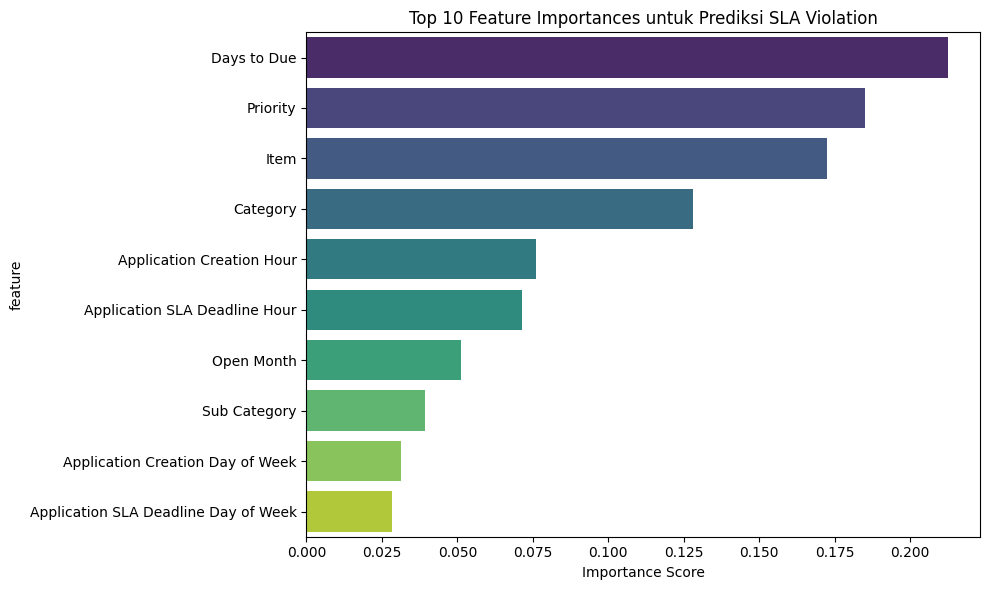

In [ ]:
# TAMBAHAN: Feature Importance
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,  # Gunakan feature_cols dari sebelumnya
    'importance': importances
}).sort_values('importance', ascending=False)

print('\nTop 10 Feature Importances:\n', feature_importance_df.head(10))

# Plot visualisasi (opsional, tapi bagus untuk skripsi)
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(10), x='importance', y='feature', palette='viridis')
plt.title('Top 10 Feature Importances untuk Prediksi SLA Violation')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [ ]:
feature_importance_list = feature_importance_df.to_dict('records')
import json
with open('feature_importances.json', 'w') as f:
    json.dump(feature_importance_list, f, indent=4)

print("Feature importances saved to feature_importances.json")

Feature importances saved to feature_importances.json


In [ ]:
kolom_untuk_dihapus = ['Closure Category']
df.drop(columns=kolom_untuk_dihapus)

,Number,Priority,Category,Open Date,Closed Date,Due Date,Time Left Incl. On Hold,Item,Sub Category,Is SLA Violated,Is Open Date Off,Is Due Date Off,Days to Due,Open Month,Application Creation Day of Week,Application Creation Hour,Application SLA Deadline Day of Week,Application SLA Deadline Hour,Resolution Duration,Total Tickets Resolved (Wc),SLA Threshold,Average Resolution Time (Ac),SLA to Average Resolution Ratio (Rc),Application SLA Compliance Rate
0,3226220,4 - low,kegagalan proses,2024-01-01 01:39:00,2024-01-03 19:03:00,2024-01-05 17:30:00,2700.0,application 84,nan,0,0,0,4,1,1,1,5,17,2.725000,1.0,0.0,5.875479,0.002340,0.860599
1,3226221,3 - medium,kegagalan proses,2024-01-01 01:50:00,2024-01-03 19:02:00,2024-01-02 17:30:00,1080.0,application 85,nan,1,0,0,1,1,1,1,2,17,2.716667,2.0,0.0,5.875479,0.002340,0.378956
2,3226222,3 - medium,kegagalan proses,2024-01-01 02:00:00,2024-01-05 19:03:00,2024-01-02 17:30:00,1038.5,application 85,nan,1,0,0,1,1,1,2,2,17,4.710417,3.0,0.0,5.875479,0.002340,0.378956
3,3226223,4 - low,event monitoring,2024-01-01 02:37:00,2024-01-04 19:00:00,2024-01-05 17:30:00,2700.0,application 344,sub kategori 49,0,0,0,4,1,1,2,5,17,3.682639,1.0,0.0,4.372967,0.001620,0.591736
4,3226224,4 - low,kegagalan proses,2024-01-01 03:17:00,2024-01-26 19:00:00,2024-01-05 17:30:00,1038.5,application 86,nan,1,0,0,4,1,1,3,5,17,25.654861,4.0,0.0,5.875479,0.002340,0.641148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49831,3449608,3 - medium,application,2024-12-29 18:22:00,2025-01-01 19:02:00,2024-12-31 17:30:00,1080.0,application 88,sub kategori 50,1,1,0,1,12,7,18,2,17,3.027778,7.0,0.0,5.559082,0.002826,0.482540
49832,3449625,3 - medium,application,2024-12-29 23:45:00,2025-01-01 19:02:00,2024-12-31 17:30:00,1080.0,application 101,sub kategori 50,1,1,0,1,12,7,23,2,17,2.803472,7.0,0.0,5.559082,0.002826,0.474286
49833,3449632,3 - medium,application,2024-12-30 02:28:00,2025-01-01 19:04:00,2024-12-31 17:30:00,1080.0,application 85,sub kategori 50,1,0,0,1,12,1,2,2,17,2.691667,7.0,0.0,5.559082,0.002826,0.378956
49834,3449636,4 - low,application,2024-12-30 05:59:00,2025-01-01 19:04:00,2025-01-03 17:30:00,2700.0,application 19,sub kategori 36,0,0,0,4,12,1,5,5,17,2.545139,7.0,0.0,5.559082,0.002826,0.925000


In [ ]:
pd.set_option('display.max_columns', None)
df.head()

,Number,Priority,Category,Open Date,Closed Date,Due Date,Time Left Incl. On Hold,Item,Sub Category,Closure Category,Is SLA Violated,Is Open Date Off,Is Due Date Off,Days to Due,Open Month,Application Creation Day of Week,Application Creation Hour,Application SLA Deadline Day of Week,Application SLA Deadline Hour,Resolution Duration,Total Tickets Resolved (Wc),SLA Threshold,Average Resolution Time (Ac),SLA to Average Resolution Ratio (Rc),Application SLA Compliance Rate
0,3226220,4 - low,kegagalan proses,2024-01-01 01:39:00,2024-01-03 19:03:00,2024-01-05 17:30:00,2700.0,application 84,nan,solved,0,0,0,4,1,1,1,5,17,2.725000,1.0,0.0,5.875479,0.00234,0.860599
1,3226221,3 - medium,kegagalan proses,2024-01-01 01:50:00,2024-01-03 19:02:00,2024-01-02 17:30:00,1080.0,application 85,nan,solved,1,0,0,1,1,1,1,2,17,2.716667,2.0,0.0,5.875479,0.00234,0.378956
2,3226222,3 - medium,kegagalan proses,2024-01-01 02:00:00,2024-01-05 19:03:00,2024-01-02 17:30:00,1038.5,application 85,nan,solved,1,0,0,1,1,1,2,2,17,4.710417,3.0,0.0,5.875479,0.00234,0.378956
3,3226223,4 - low,event monitoring,2024-01-01 02:37:00,2024-01-04 19:00:00,2024-01-05 17:30:00,2700.0,application 344,sub kategori 49,solved,0,0,0,4,1,1,2,5,17,3.682639,1.0,0.0,4.372967,0.00162,0.591736
4,3226224,4 - low,kegagalan proses,2024-01-01 03:17:00,2024-01-26 19:00:00,2024-01-05 17:30:00,1038.5,application 86,nan,solved,1,0,0,4,1,1,3,5,17,25.654861,4.0,0.0,5.875479,0.00234,0.641148


In [ ]:
df.to_csv('dataset_random-forest.csv', index=False)
df.to_excel('dataset_random-forest.xlsx', index=False, sheet_name='Data Utama')

In [ ]:
import joblib

# Asumsi: rf_model sudah fit, encoders & scaler dari atas
try:
    # Save model RF
    joblib.dump(rf_model, 'rf_sla_model.pkl')

    # Save encoders (dict untuk multiple kolom)
    joblib.dump(encoders, 'label_encoders.pkl')  # Semua le dalam dict

    # Save scaler
    joblib.dump(scaler, 'minmax_scaler.pkl')

    # Save feature names
    feature_names = X_train.columns.tolist()
    joblib.dump(feature_names, 'feature_names.pkl')

    print("Model & artifacts saved! Files:")
    print("- rf_sla_model.pkl (Random Forest)")
    print("- label_encoders.pkl (Dict encoders per kolom)")
    print("- minmax_scaler.pkl (Scaler)")
    print("- feature_names.pkl (Kolom features)")

    # Test load & predict dummy
    loaded_model = joblib.load('rf_sla_model.pkl')
    dummy_X = np.zeros((1, len(feature_names)))
    pred = loaded_model.predict(dummy_X)[0]
    prob = loaded_model.predict_proba(dummy_X)[0][1]
    print(f"Test: Prediction = {pred}, Probability Violated = {prob:.2f}")

except NameError as e:
    print(f"Error: {e}. Pastikan rf_model, encoders, scaler, X_train ada.")
except Exception as e:
    print(f"Unexpected error: {e}")

Model & artifacts saved! Files:
- rf_sla_model.pkl (Random Forest)
- label_encoders.pkl (Dict encoders per kolom)
- minmax_scaler.pkl (Scaler)
- feature_names.pkl (Kolom features)
Test: Prediction = 1, Probability Violated = 0.97


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
